# Model training

Baseline is the simplest algorithm that provides predictions without complex computations.
For regression tasks, the Baseline returns the average of the target from training data.

In [1]:
%load_ext jupyter_black

In [2]:
import statistics

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from utils import get_training_dataset

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Read csv file and import to df
df = get_training_dataset()

array([[<AxesSubplot:title={'center':'percent_buildings_damaged'}>]],
      dtype=object)

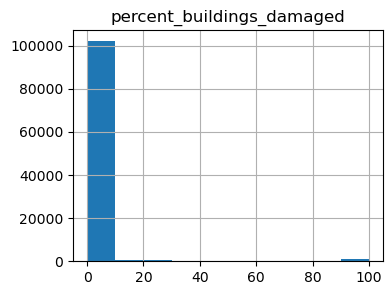

In [4]:
# Show histogram of damage
df.hist(column="percent_buildings_damaged", figsize=(4, 3))

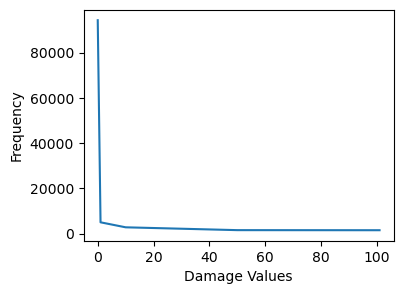

In [5]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_buildings_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [6]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]

df = df.drop(columns=["grid_point_id", "typhoon_year"])
df

,typhoon_name,wind_speed,track_distance,total_buildings,percent_buildings_damaged
48,DURIAN,13.077471,262.598363,35.0,0.0
49,DURIAN,12.511864,273.639330,179.0,0.0
50,DURIAN,11.977511,284.680297,44.0,0.0
51,DURIAN,11.471921,295.721263,14.0,0.0
59,DURIAN,14.394863,239.279840,5.0,0.0
...,...,...,...,...,...
104790,MOLAVE,8.011792,255.535258,61.0,0.0
104791,MOLAVE,7.617460,266.645258,2070.0,0.0
104792,MOLAVE,7.170117,277.755258,997.0,0.0
104815,MOLAVE,6.834925,288.864374,134.0,0.0


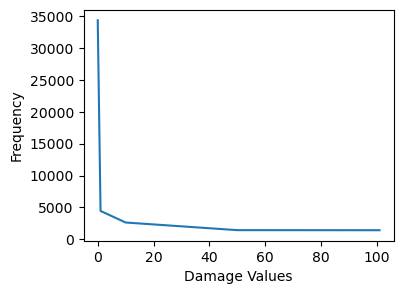

In [7]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_buildings_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [8]:
print(samples_per_bin2)
print(binsP2)

[34366  4458  2643  1446  1434]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [9]:
# Check the bins' intervalls
# df["percent_buildings_damaged"].value_counts(bins=binsP2)

In [10]:
bin_index2 = np.digitize(df["percent_buildings_damaged"], bins=binsP2)

In [11]:
y_input_strat = bin_index2

In [12]:
# Split X and y from dataframe features

features = ["track_distance", "wind_speed", "total_buildings"]
X = df[features]
display(X.columns)
y = df["percent_buildings_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['track_distance', 'wind_speed', 'total_buildings'], dtype='object')

In [13]:
# Define train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["percent_buildings_damaged"], stratify=y_input_strat, test_size=0.2
)

In [14]:
def create_dummy(X_train, X_test, y_train, y_test, num_bin):
    # create a dummy regressor
    dummy_reg = DummyRegressor(strategy="mean")

    # fit it on the training set
    dummy_reg.fit(X_train, y_train)

    # make predictions on the test set
    y_pred = dummy_reg.predict(X_test)
    y_pred_train = dummy_reg.predict(X_train)

    bin_index_test = np.digitize(y_test, bins=binsP2)
    bin_index_train = np.digitize(y_train, bins=binsP2)

    # Estimation of RMSE for train data per each bin
    mse_train = mean_squared_error(
        y_train[bin_index_train == num_bin], y_pred_train[bin_index_train == num_bin]
    )
    rmse_train = np.sqrt(mse_train)

    # Estimation of RMSE for test data per each bin
    mse = mean_squared_error(
        y_test[bin_index_test == num_bin], y_pred[bin_index_test == num_bin]
    )
    rmse = np.sqrt(mse)

    print(f"RMSE per bin")
    print(f"Dummy_RMSE_test per bin: {rmse:.2f}")
    print(f"Dummy_RMSE_train per bin: {rmse_train:.2f}", "\n")

    # calculate root mean squared error in total
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    print(f"RMSE in total")
    print(f"total_RMSE_test: {rmse:.2f}")
    print(f"total_RMSE_train: {rmse_train:.2f}")

In [15]:
# Insert the number of bin
create_dummy(X_train, X_test, y_train, y_test, 2)

RMSE per bin
Dummy_RMSE_test per bin: 3.76
Dummy_RMSE_train per bin: 3.76 

RMSE in total
total_RMSE_test: 16.96
total_RMSE_train: 16.72
